In [1]:
import pandas as pd 
import os
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product
import pickle
import seaborn as sns


# This var is to control if we train the ARIMA model.
# False means it will skip training part, and best model will assign in code. 
# In the final adjustment stage, keep it True to save time.
TRAIN_MODEL = True
title_fontsize = 16

def load_csv_data(file_name, _path):
    file_path = os.path.join(_path, file_name)
    return pd.read_csv(file_path)

def arima_predict(order, data):
    # build ARIMA model
    model = ARIMA(df['theme_id'], order=order)
    results = model.fit()

    # model forecast
    forecast_steps = 10
    forecast = results.get_forecast(steps=forecast_steps)
    predicted_values = forecast.predicted_mean
    return predicted_values


def plot_result(data,predicted_values):
    # plot the result of forecast
    plt.plot(data, label='Original')
    plt.plot(predicted_values.index, predicted_values.values, color='red', label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Theme ID')
    plt.title(f'Number of Themes ARIMA Model Forecast p:{order[0]} d:{order[1]} q: {order[2]}')
    plt.legend()
    plt.show()

data_path = os.path.join("data")
files = os.listdir(data_path)

files_csv = [f for f in files if f[-4:] == '.csv'] # find all files ending with '.csv'

dataset = {} 
for i in range(len(files_csv)):
    dataset[files_csv[i][:-4]] = load_csv_data(files_csv[i], data_path)


df_sets = dataset['sets']


column_to_plot = 'num_parts'
# group by the 'column_to_plot' and display
df_group_part = df_sets.groupby('year')[[column_to_plot]].mean()

df_group_theme = df_sets.groupby('year')[['theme_id']].nunique()


## number of unique themes every year

ADF Statistic: 0.010593414050509653 p-value: 0.9593994351534729


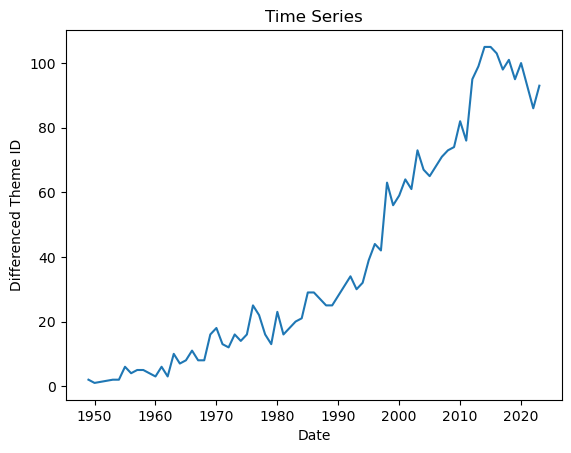

ADF Statistic: -11.430070877174181 p-value: 6.5495892937777446e-21


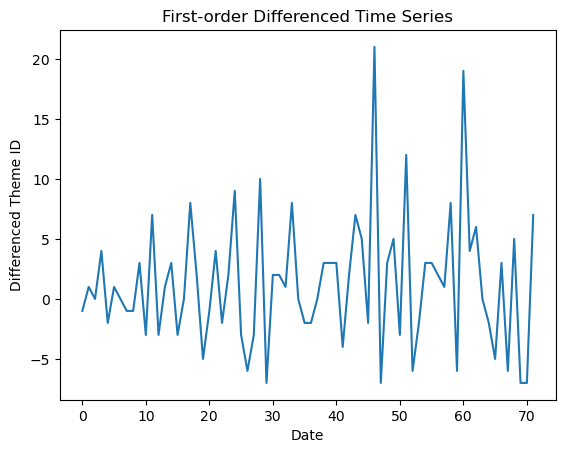

In [2]:
df = df_group_theme.loc[:2023]

# unit root test
result = adfuller(df['theme_id'])
print('ADF Statistic:', str(result[0]), 'p-value:', result[1])

if True:
    plt.plot(df['theme_id'])
    plt.xlabel('Date')
    plt.ylabel('Differenced Theme ID')
    plt.title('Time Series')
    plt.show()


# first-order differencing
df_diff = df.diff().dropna()
df_diff.reset_index(inplace = True)
df.reset_index(inplace = True)

# unit root test
result_diff = adfuller(df_diff['theme_id'])
print('ADF Statistic:', str(result_diff[0]), 'p-value:', result_diff[1])
plt.plot(df_diff['theme_id'])
plt.xlabel('Date')
plt.ylabel('Differenced Theme ID')
plt.title('First-order Differenced Time Series')
plt.show()

if False:
    df_diff = df_diff.diff().dropna()
    df_diff.reset_index(inplace = True)
    df.reset_index(inplace = True)

    # unit root test
    result_diff = adfuller(df_diff['theme_id'])
    print('ADF Statistic:', result_diff[0], 'p-value:', result_diff[1])

    plt.plot(df_diff['theme_id'])
    plt.xlabel('Date')
    plt.ylabel('Differenced Theme ID')
    plt.title('Second-order Differenced Time Series')
    plt.show()


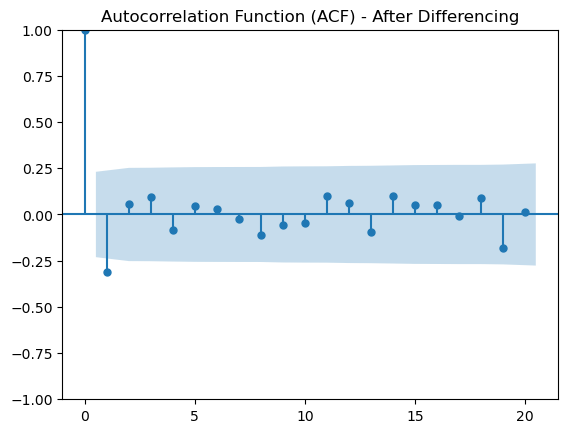

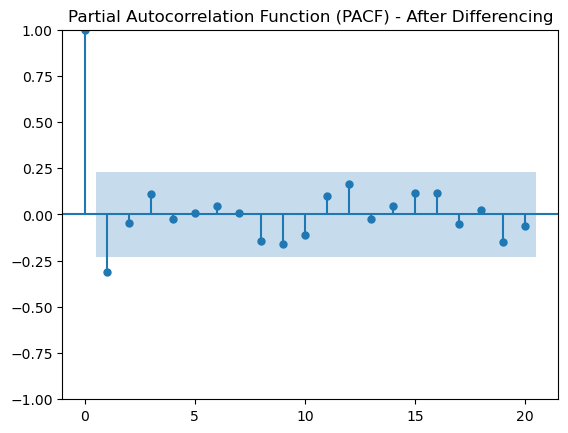

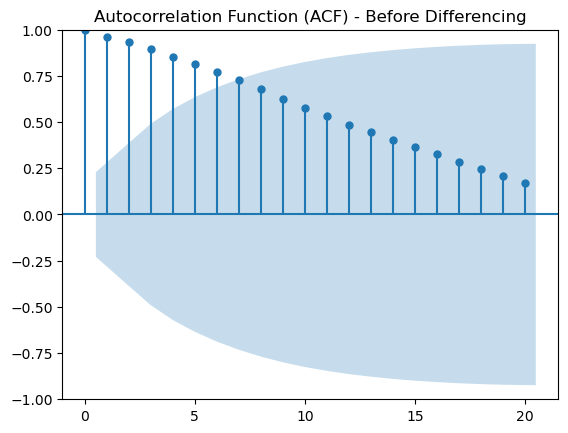

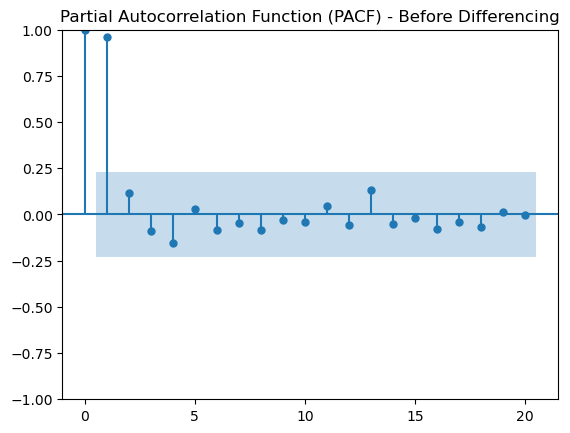

In [3]:

# Plot autocorrelation and partial autocorrelation after differencing
plot_acf(df_diff['theme_id'], lags=20)
plt.title('Autocorrelation Function (ACF) - After Differencing')
plt.show()

plot_pacf(df_diff['theme_id'], lags=20)
plt.title('Partial Autocorrelation Function (PACF) - After Differencing')
plt.show()



# Plot autocorrelation and partial autocorrelation after differencing
plot_acf(df['theme_id'], lags=20)
plt.title('Autocorrelation Function (ACF) - Before Differencing')
plt.show()

plot_pacf(df['theme_id'], lags=20)
plt.title('Partial Autocorrelation Function (PACF) - Before Differencing')
plt.show()



2 1 2 695.1182543181749
2 1 3 687.1384516691035
2 1 4 684.2857185122991
2 1 5 630.5095404631269
2 1 6 533.6825523142013
4 1 7 518.459506449024
5 1 6 447.9886412103127
6 1 3 324.2548449194321
6 1 6 182.4645744585256
Best Parameters: (6, 1, 6)


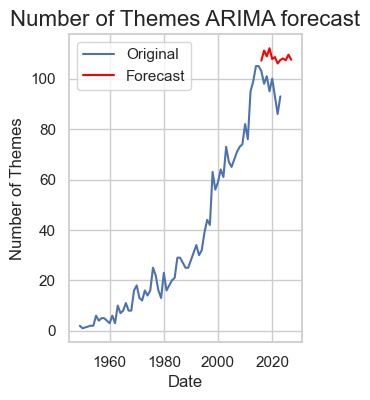

In [4]:

warnings.filterwarnings("ignore")

time_series_data = df['theme_id']
# split data
train_size = int(len(time_series_data) * 0.9)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# params range
p_range = range(2, 8)  
d_range = range(1, 3) 
q_range = range(2, 8) 

# grid search
param_grid = list(product(p_range, d_range, q_range))

best_score, best_params, best_model = float('inf'), None, None

for param in param_grid:
    if TRAIN_MODEL:
        p, d, q = param
        arima_model = ARIMA(train, order=(p, d, q))
        arima_result = arima_model.fit()

        forecast_steps = len(test)
        forecast = arima_result.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean

        mse = mean_squared_error(test, forecast_mean)
        
        if mse < best_score:
            best_score, best_params, best_model = mse, param, arima_result
            print(p,d,q,mse)

if not TRAIN_MODEL:
    best_params = (6, 1, 6)
# best_params
print('Best Parameters:', best_params)

# Build ARIMA model
model = ARIMA(df['theme_id'][:train_size], order=best_params)
results = model.fit()

forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

figsize=(3,4)
# ARIMA predict
sns.set(style="whitegrid")
plt.figure(figsize=figsize)
plt.plot(df['year'], df['theme_id'], label='Original')
plt.plot(predicted_values.index +1951, predicted_values.values, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Themes')
plt.title('Number of Themes ARIMA forecast',fontsize = title_fontsize)
plt.legend()
plt.show()


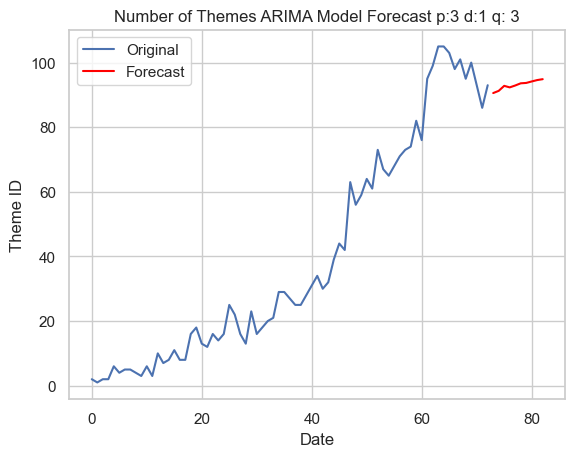

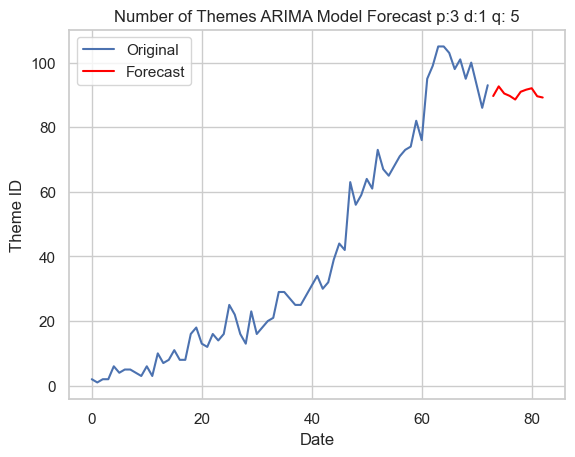

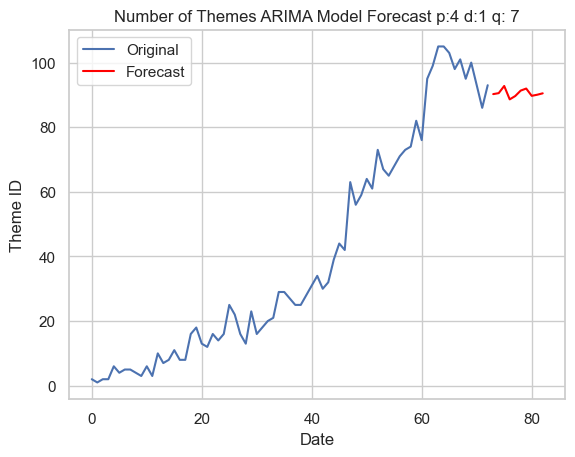

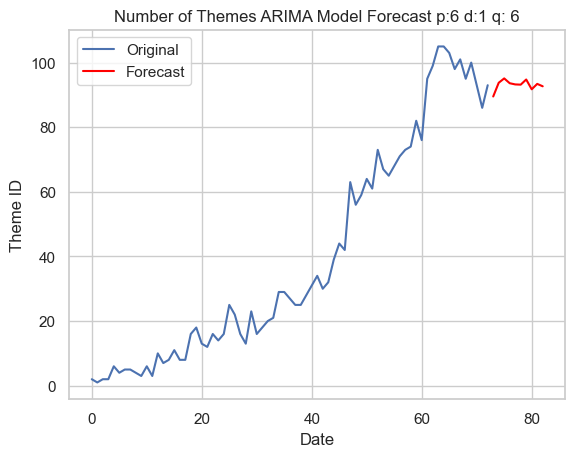

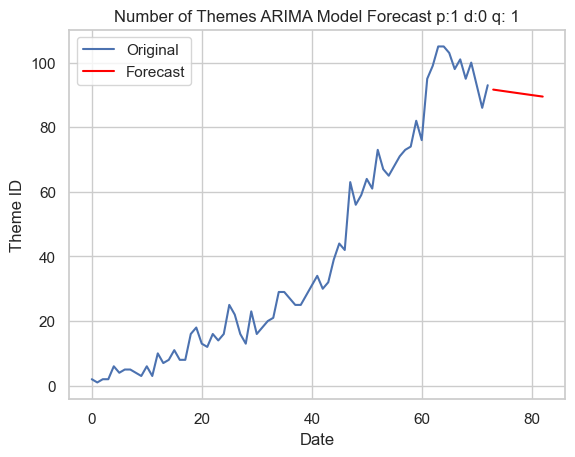

In [5]:
orders = [(3,1,3), (3,1,5), (4,1,7), (6,1,6),(1,0,1)]
#2 0 2 76.30464573918263     5 0 5 64.50323661975825


for order in orders:
    predicted_values = arima_predict(order,df['theme_id'][:train_size])
    plot_result(df['theme_id'], predicted_values)

## number of parts in set every year

ADF Statistic: 0.9481213263805186
p-value: 0.9936872593149241
ADF Statistic: -2.869372868662944
p-value: 0.049027194810088506


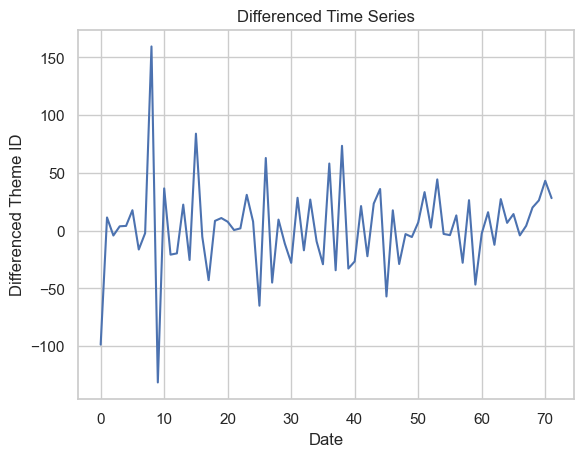

In [6]:
# unit root test
df = df_group_part.loc[:2023] 
result = adfuller(df['num_parts'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# first-order differencing
df_diff = df.diff().dropna()
df_diff.reset_index(inplace = True)
df.reset_index(inplace = True)

# unit root test
result_diff = adfuller(df_diff['num_parts'])
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

plt.plot(df_diff['num_parts'])
plt.xlabel('Date')
plt.ylabel('Differenced Theme ID')
plt.title('Differenced Time Series')
plt.show()


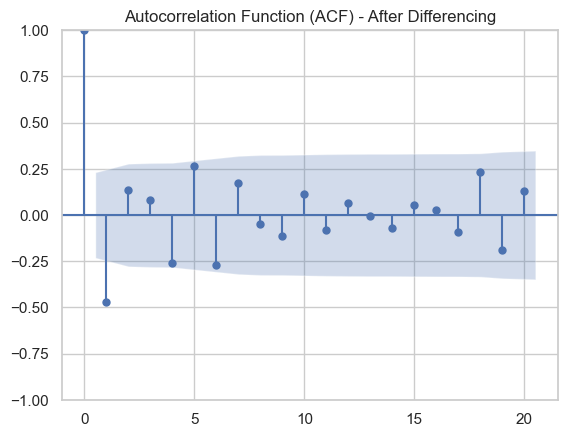

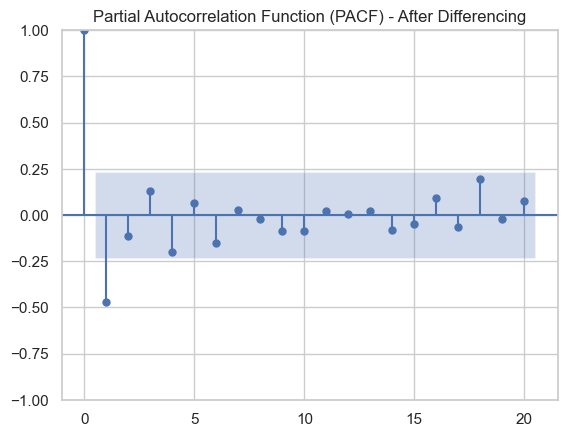

In [7]:
# Plot autocorrelation and partial autocorrelation after differencing
plot_acf(df_diff['num_parts'], lags=20)
plt.title('Autocorrelation Function (ACF) - After Differencing')
plt.show()

plot_pacf(df_diff['num_parts'], lags=20)
plt.title('Partial Autocorrelation Function (PACF) - After Differencing')
plt.show()


3 1 3 6759.129015443259
3 1 4 6735.953175268723
3 1 5 6500.675944517618
3 1 7 5224.78841076342
3 2 3 4647.511053670888
3 2 4 4246.366022361949
3 2 6 4211.095740654522
4 2 5 4144.710629557193
4 2 6 4091.392155739526
5 2 7 3970.1929010312974
7 1 6 2989.7611448946227
Best Parameters: (7, 1, 6)


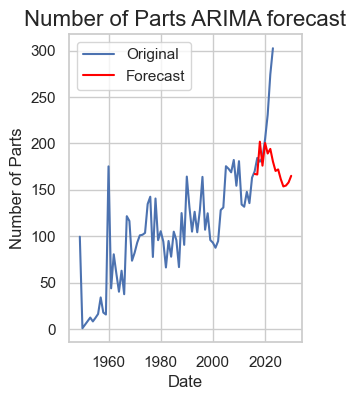

In [8]:

warnings.filterwarnings("ignore")

time_series_data = df['num_parts']
# split data
train_size = int(len(time_series_data) * 0.9)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# params range  # compare starting from 1 and 3, to show what is overfitting
p_range = range(3, 8)  
d_range = range(1, 3) 
q_range = range(3, 8) 

# grid search
param_grid = list(product(p_range, d_range, q_range))

best_score, best_params, best_model = float('inf'), None, None

for param in param_grid:
    if TRAIN_MODEL:
        p, d, q = param
        arima_model = ARIMA(train, order=(p, d, q))
        arima_result = arima_model.fit()

        forecast_steps = len(test)
        forecast = arima_result.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean

        mse = mean_squared_error(test, forecast_mean)
        
        if mse < best_score:
            best_score, best_params, best_model = mse, param, arima_result
            print(p,d,q,mse)


# best_params
if not TRAIN_MODEL:
    best_params = (7, 1, 6)
print('Best Parameters:', best_params)


# ARIMA model
model = ARIMA(df['num_parts'][:train_size], order=best_params)
results = model.fit()

# ARIMA predict
forecast_steps = 15
forecast = results.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

plt.figure(figsize=figsize)
plt.plot(df['year'],df['num_parts'], label='Original')
plt.plot(predicted_values.index+1951, predicted_values.values, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Parts')
plt.title('Number of Parts ARIMA forecast',fontsize = title_fontsize)
plt.legend()
plt.show()


In [9]:
PKL_DF_ALL = r'data/df_all.pkl'
with open(PKL_DF_ALL, 'rb') as file:
    df_all = pickle.load(file)


In [10]:
df = df_all.groupby('year').nunique()

ADF Statistic: -1.0810345719162069
p-value: 0.7225755400383043
ADF Statistic: -10.538470441523236
p-value: 8.77500820505964e-19


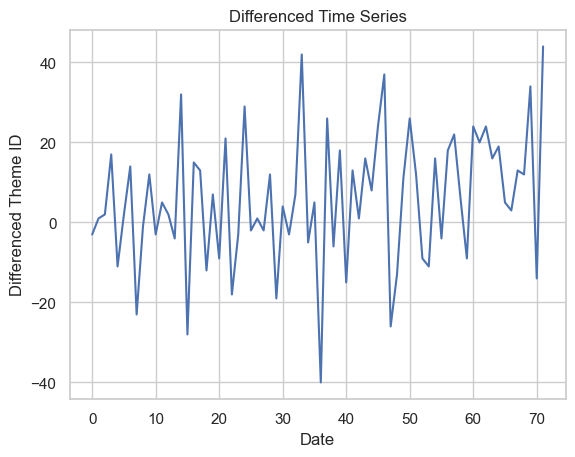

In [11]:
# unit root test
result = adfuller(df['color_id'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# first-order differencing
df_diff = df.diff().dropna()
df_diff.reset_index(inplace = True)
df.reset_index(inplace = True)

# unit root test
result_diff = adfuller(df_diff['num_parts'])
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

plt.plot(df_diff['num_parts'])
plt.xlabel('Date')
plt.ylabel('Differenced Theme ID')
plt.title('Differenced Time Series')
plt.show()


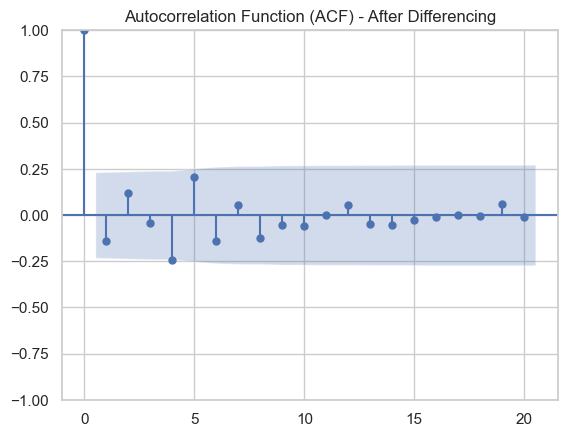

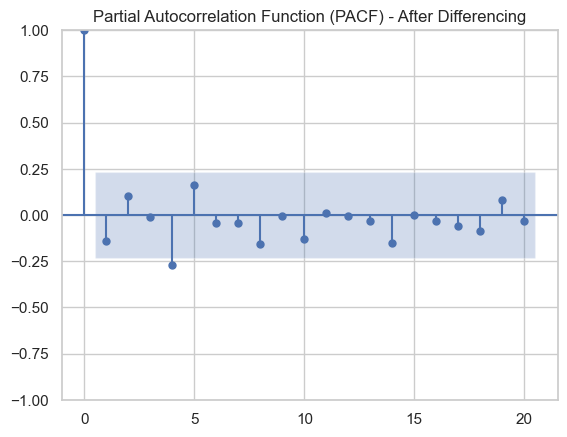

In [12]:
# Plot autocorrelation and partial autocorrelation after differencing
plot_acf(df_diff['color_id'], lags=20)
plt.title('Autocorrelation Function (ACF) - After Differencing')
plt.show()

plot_pacf(df_diff['color_id'], lags=20)
plt.title('Partial Autocorrelation Function (PACF) - After Differencing')
plt.show()


2 1 2 23.584948716027675
2 1 3 23.008562528279505
2 2 2 11.707049700213217
2 2 3 10.866241508720373
Best Parameters: (2, 2, 3)


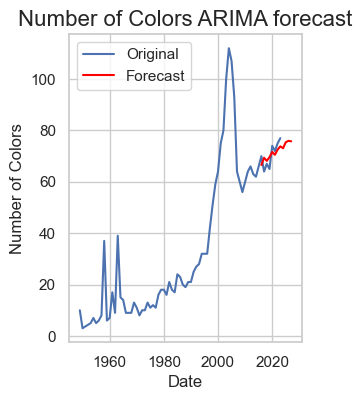

In [13]:
#figsize=(3,4)
warnings.filterwarnings("ignore")

time_series_data = df['color_id']
# split data
train_size = int(len(time_series_data) * 0.9)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# params range  # compare starting from 1 and 3, to show what is overfitting
p_range = range(2, 6)  
d_range = range(1, 3) 
q_range = range(2, 6) 

# grid search
param_grid = list(product(p_range, d_range, q_range))

best_score, best_params, best_model = float('inf'), None, None

for param in param_grid:
    if TRAIN_MODEL:
        p, d, q = param
        arima_model = ARIMA(train, order=(p, d, q))
        arima_result = arima_model.fit()

        forecast_steps = len(test)
        forecast = arima_result.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean

        mse = mean_squared_error(test, forecast_mean)
        
        if mse < best_score:
            best_score, best_params, best_model = mse, param, arima_result
            print(p,d,q,mse)


# best_params
if not TRAIN_MODEL:
    best_params = (2, 2, 3)
print('Best Parameters:', best_params)

# ARIMA model
model = ARIMA(df['color_id'][:train_size], order=best_params)
results = model.fit()

# ARIMA predict
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

plt.figure(figsize=figsize)
plt.plot(df['year'],df['color_id'], label='Original')
plt.plot(predicted_values.index+1951, predicted_values.values, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Colors')
plt.title('Number of Colors ARIMA forecast',fontsize = title_fontsize)
plt.legend()
plt.show()


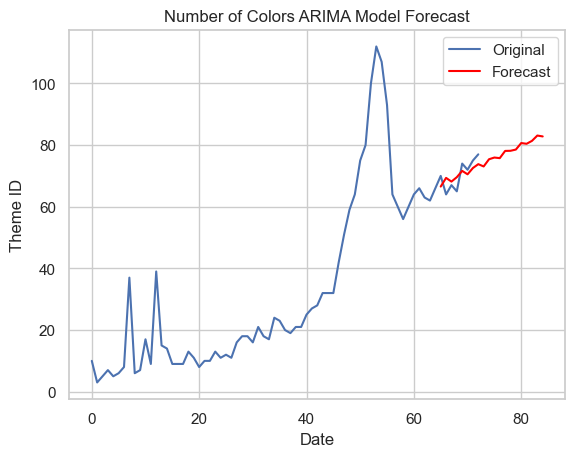

In [14]:
# ARIMA model
order = (2,2,3)
model = ARIMA(df['color_id'][:train_size], order=order)
results = model.fit()

# ARIMA predict
forecast_steps = 20
forecast = results.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

plt.plot(df['color_id'], label='Original')
plt.plot(predicted_values.index, predicted_values.values, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Theme ID')
plt.title('Number of Colors ARIMA Model Forecast')
plt.legend()
plt.show()

In [15]:
temp = dataset['themes'].copy()
temp = temp.merge(temp[['id','name']],how = 'left', left_on = 'parent_id', right_on = 'id')[['id_x','name_x','parent_id','name_y']]
temp.rename(columns = {'id_x':'theme_id', 'name_x':'theme_name', 'parent_id':'theme_parent_id' 
                       , 'name_y': 'theme_parent_name'}, inplace = True)
df_theme = temp 
del temp 

df_set_theme =  dataset['sets'].merge(df_theme, how = 'left', on = 'theme_id')
df_set_theme = df_set_theme[df_set_theme['year'] != 2024]
display(
    df_theme.head(3)
    ,df_set_theme.head(3)
)

,theme_id,theme_name,theme_parent_id,theme_parent_name
0,1,Technic,NaN,NaN
1,3,Competition,1.0,Technic
2,4,Expert Builder,1.0,Technic


,set_num,name,year,theme_id,num_parts,img_url,theme_name,theme_parent_id,theme_parent_name
0,001-1,Gears,1965,1,43,https://cdn.rebrickable.com/media/sets/001-1.jpg,Technic,NaN,NaN
1,0011-2,Town Mini-Figures,1979,67,12,https://cdn.rebrickable.com/media/sets/0011-2.jpg,Classic Town,50.0,Town
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0,https://cdn.rebrickable.com/media/sets/0011-3.jpg,Lion Knights,186.0,Castle
